@todo: batch effects from the 

# 0. Load data

In [47]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output
    
def predict_feature(df:pd.DataFrame,
                    classifier,
                    feature2predict,
                    Niter:int=100,
                    rebalance:bool=True,
                    subsample=None,
                    measurement_level_name:str='Measurement'):
    if subsample == None:
        subsample = len(df)
    Y_test = []
    Y_pred = []
    models = []
    for i in tqdm(range(Niter)):

        # rng = np.random.RandomState(0)
        df_ = get_balanced_df_by_category(df, df[feature2predict,'Meta'].values)
        pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      feature_selection.SelectFromModel(classifier()),
                                      classifier() )
        
        y = df_[feature2predict,'Meta'].astype(float)
        X = df_.xs(measurement_level_name,level=1,axis=1).astype(float)
        X[np.isinf(X)] = np.nan
        X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
        
        model = pipe.fit(X_train,y_train)
        models.append(model)
        
        Y_test.append(y_test)
        Y_pred.append(model.predict(X_test))
        
    return [np.stack((np.array(Y_test),np.array(Y_pred))),models]
    
import umap

# Suppress batch effects
def scale_by_region(df):
    scaled = []
    for region,_df in df.groupby('Region'):
        _X = preprocessing.StandardScaler().fit_transform(_df.drop(columns='Region'))
        _df = pd.DataFrame(index=_df.index,columns=_df.drop(columns='Region').columns,
                           data=_X)
        _df['Region'] = region
        scaled.append(_df)
    return pd.concat(scaled)
    

In [48]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = all_df[all_df['Cell type','Meta'] == 'Basal']
basals = basals[~basals['Border','Meta'].astype(bool)]

cols2drop = [(f,'Measurement') for f in basals.droplevel(axis=1,level=1) if 'Age' in f]
cols2drop += [(f,'Measurement') for f in basals.droplevel(axis=1,level=1) if 'Time' in f]
cols2drop += [(f,'Measurement') for f in basals.droplevel(axis=1,level=1) if 'Gaussian' in f]
basals = basals.drop(columns=cols2drop)
basals.shape


(8215, 1380)

### Separate measurement fields into constituent types
1. 'geom': Cell geometry
2. 'temporal': Cell rates and lookbacks
3. 'adjac': microenvironment/relative

In [83]:
# Filter only for geom features

meas_names = basals.xs('Measurement',level=1,axis=1).columns
meas_types = pd.DataFrame(index=meas_names)
meas_types['Type'] = 'geom'
meas_types.loc[ meas_names.str.contains('rate'),'Type' ] = 'rate'
meas_types.loc[ meas_names.str.contains('adjac'),'Type' ] = 'adjac'
meas_types.loc[ meas_names.str.contains('duration'),'Type' ] = 'duration'
meas_types.loc[ meas_names.str.contains('neighbors'),'Type' ] = 'adjac'
meas_types.loc[ meas_names.str.contains('Relative'),'Type' ] = 'relative'
meas_types.loc[ meas_names.str.contains('prior'),'Type' ] = 'temporal'

# cols2keep = [(f,'Measurement') for f in meas_types[meas_types['Type'] == 'geom'].index]
cols2keep += [(f,'Measurement') for f in meas_types[meas_types['Type'] == 'temporal'].index]
cols2keep += [(f,'Measurement') for f in meas_types[meas_types['Type'] == 'adjac'].index]
metacols = [(f,'Meta') for f in basals.xs('Meta',level=1,axis=1)]

all_meas = basals[cols2keep]
all_meas = all_meas.dropna(subset=cols2keep,axis=0)
all_meas['Region'] = basals['Region']
all_meas

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_62465/3873585799.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_meas['Region'] = basals['Region']


Name          Nuclear volume Nuclear solidity           Z           Y  \
Metadata         Measurement      Measurement Measurement Measurement   
Frame TrackID                                                           
1     R1_11         114.9375         0.852573   44.208809  102.628603   
      R1_31         176.4375         0.846223   47.328374   25.138062   
      R1_60         131.7500         0.803966   46.293169  100.852467   
      R1_64         169.0000         0.926027   47.824704   25.978458   
      R1_71         125.2500         0.805143   51.640220   52.802146   
...                      ...              ...         ...         ...   
14    R2_880        253.0625         0.919809   55.200049   77.580082   
      R2_881        279.0000         0.909906   55.582661   85.625112   
      R2_1057       137.0000         0.872611   43.682026   96.133326   
      R2_1058       136.8750         0.899384   47.228767   93.814155   
      R2_1087       125.6875         0.787392   52.773247   83.006340   

Name                    X Nuclear height Cell volume      Z-cyto      Y-cyto  \
Metadata      Measurement    Measurement Measurement Measurement Measurement   
Frame TrackID                                                                  
1     R1_11     35.245242          -12.0    376.8125   44.568917  102.653964   
      R1_31     35.516383          -11.0    381.6875   47.072376   25.119985   
      R1_60     39.210033          -11.0    430.5625   45.865438  101.234359   
      R1_64    108.396542          -11.0    505.0000   47.346163   26.238274   
      R1_71     11.936876          -11.0    372.2500   51.399597   52.925034   
...                   ...            ...         ...         ...         ...   
14    R2_880   101.209558          -11.0    703.0000   54.491198   78.134891   
      R2_881   102.665099          -13.0    708.3125   55.468367   85.797715   
      R2_1057   38.064667           -9.0    440.4375   43.366113   96.260004   
      R2_1058   33.073858           -9.0    499.8750   47.229057   94.376532   
      R2_1087   19.491546          -12.0    450.0000   51.852500   82.801632   

Name               X-cyto  ... Std adjac Distance to closest macrophage  \
Metadata      Measurement  ...                              Measurement   
Frame TrackID              ...                                            
1     R1_11     35.176771  ...                                 4.526654   
      R1_31     35.491813  ...                                 1.658751   
      R1_60     39.286507  ...                                 3.492019   
      R1_64    108.671225  ...                                 2.810705   
      R1_71     12.042772  ...                                 1.473597   
...                   ...  ...                                      ...   
14    R2_880   101.039963  ...                                 2.352355   
      R2_881   102.931086  ...                                 1.968221   
      R2_1057   37.970448  ...                                 2.115730   
      R2_1058   33.252907  ...                                 4.179398   
      R2_1087   19.208264  ...                                 2.110473   

Name          Std adjac Nuclear volume standard  \
Metadata                            Measurement   
Frame TrackID                                     
1     R1_11                            0.088407   
      R1_31                            0.230371   
      R1_60                            0.104616   
      R1_64                            0.301884   
      R1_71                            0.136630   
...                                         ...   
14    R2_880                           0.321291   
      R2_881                           0.333564   
      R2_1057                          0.153841   
      R2_1058                          0.258032   
      R2_1087                          0.152408   

Name          Std adjac Cell volume standard  \
Metadata                         Measureme

In [84]:
# Standardize

meas_scaled_by_region = scale_by_region(all_meas)
scaled_data = meas_scaled_by_region.drop(columns='Region')

# 1. Reduce batch effect

[https://github.com/CoAxLab/pycombat]
These input data consist of the following ingredients:

    Y: The matrix of response variables, with dimensions [observations x features]
    b: The array of batch label for each observation. In principle these could be labelled as numbers or strings.
    X: The matrix of effects of interest to keep, with dimensions [observations x features_interest]
    C: The matrix of covariates to remove, with dimensions [observations x features_covariates]


In [85]:
scaled_data

Name          Nuclear volume Nuclear solidity           Z           Y  \
Metadata         Measurement      Measurement Measurement Measurement   
Frame TrackID                                                           
1     R1_11        -1.448404        -0.505479   -1.438592    1.421596   
      R1_31         0.098759        -0.674579   -0.570604   -1.212235   
      R1_60        -1.025450        -1.799871   -0.858639    1.361227   
      R1_64        -0.088347         1.450610   -0.432505   -1.183671   
      R1_71        -1.188971        -1.768549    0.629126   -0.271959   
...                      ...              ...         ...         ...   
14    R2_880        2.896446         1.460726    0.108350    0.663967   
      R2_881        3.648723         1.170791    0.221205    0.949556   
      R2_1057      -0.469770         0.078889   -3.288976    1.322584   
      R2_1058      -0.473395         0.862725   -2.242838    1.240257   
      R2_1087      -0.797871        -2.416126   -0.607453    0.856593   

Name                    X Nuclear height Cell volume      Z-cyto      Y-cyto  \
Metadata      Measurement    Measurement Measurement Measurement Measurement   
Frame TrackID                                                                  
1     R1_11     -0.827650      -0.454665   -0.837851   -1.359625    1.420197   
      R1_31     -0.818193       0.218913   -0.790482   -0.617802   -1.215599   
      R1_60     -0.689368       0.218913   -0.315576   -0.975441    1.371937   
      R1_64      1.723675       0.218913    0.407714   -0.536674   -1.177583   
      R1_71     -1.640584       0.218913   -0.882184    0.664436   -0.270357   
...                   ...            ...         ...         ...         ...   
14    R2_880     1.627222      -0.579462    2.378311   -0.044052    0.681693   
      R2_881     1.679128      -2.149871    2.429293    0.244808    0.953568   
      R2_1057   -0.624584       0.990947   -0.141410   -3.332736    1.324768   
      R2_1058   -0.802561       0.990947    0.428991   -2.190812    1.257943   
      R2_1087   -1.286919      -1.364666   -0.049642   -0.824077    0.847268   

Name               X-cyto  ... Std adjac nuc_shcoeffs_surface_area  \
Metadata      Measurement  ...                         Measurement   
Frame TrackID              ...                                       
1     R1_11     -0.832710  ...                           -1.249307   
      R1_31     -0.821727  ...                           -0.030196   
      R1_60     -0.689441  ...                           -0.879568   
      R1_64      1.729368  ...                            0.553334   
      R1_71     -1.639180  ...                           -0.890757   
...                   ...  ...                                 ...   
14    R2_880     1.622064  ...                            0.982573   
      R2_881     1.689442  ...                            1.017948   
      R2_1057   -0.625011  ...                           -0.402380   
      R2_1058   -0.793090  ...                            0.327727   
      R2_1087   -1.293480  ...                           -0.795331   

Name          Std adjac Distance to closest macrophage  \
Metadata                                   Measurement   
Frame TrackID                                            
1     R1_11                                   2.389234   
      R1_31                                  -0.979402   
      R1_60                                   1.173952   
      R1_64                                   0.373682   
      R1_71                                  -1.196884   
...                                                ...   
14    R2_880                                 -0.100516   
      R2_881                                 -0.587200   
      R2_1057                                -0.400311   
      R2_1058                                 2.214279   
      R2_1087                                -0.406972   

Name          Std adjac Nuclear volume standard  \
Metadata   

In [86]:
# import libraries
from combat.pycombat import pycombat

# scaled_data = pycombat(scaled_data.T,all_meas['Region'].values).T
# scaled_data

### Try a bunch of hyperparameters

In [94]:
from itertools import product

_mapped = pd.DataFrame(index=all_meas.index)
_mapped['Region'] = basals['Region']
_mapped['Cell state'] = basals['Cell cycle phase','Meta']
_mapped.loc[basals['Birth frame','Meta'].astype(bool),'Cell state'] = 'Birth'
_mapped.loc[basals['Divide next frame','Meta'].astype(bool),'Cell state'] = 'Dividing'
_mapped.loc[basals['Will differentiate','Meta'].astype(bool),'Cell state'] = 'Differentiating'
# _mapped.loc[basals['Delaminate next frame','Meta'].astype(bool),'Cell state'] = 'Delaminating'

num_neighbors2try = [5,10,25]
min_dist2try = [0.0,0.1,0.2,0.5,0.8,1]
parameters = product(num_neighbors2try,min_dist2try)
mapped = []

for num_neighbors,min_dist in tqdm(parameters):
    
    reducer = umap.UMAP(n_neighbors=num_neighbors,min_dist=min_dist)
    embedding = reducer.fit_transform(scaled_data)
    _this_mapped = _mapped.copy()
    
    _this_mapped['Umap1'] = embedding[:,0]
    _this_mapped['Umap2'] = embedding[:,1]
    _this_mapped['Num neighbors'] = num_neighbors
    _this_mapped['Min dist'] = min_dist

    mapped.append(_this_mapped)

mapped = pd.concat(mapped,ignore_index=True)

18it [01:42,  5.69s/it]


In [95]:
scaled_data.shape

(3353, 2334)

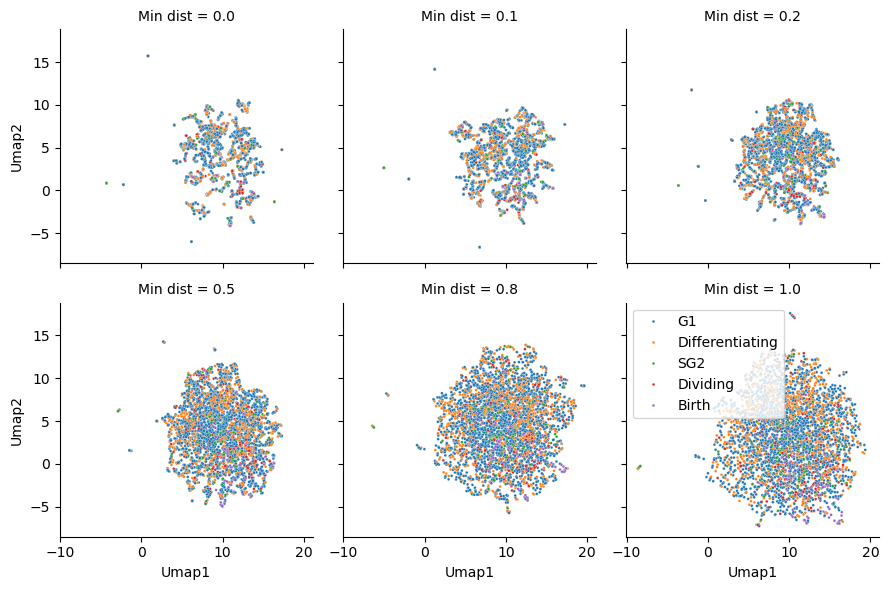

In [96]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2              # <---- set markersize here
g = sb.FacetGrid(data=mapped[mapped['Num neighbors']==5],col_wrap=3,col='Min dist')
g.map_dataframe(sb.scatterplot,data=mapped,x='Umap1',y='Umap2',
                hue='Cell state',alpha=1)
plt.legend()

Obvious batch effects... but is it biological?

### Stability test

In [91]:
Niter = 6

_mapped = pd.DataFrame(index=all_meas.index)
_mapped['Region'] = basals['Region']
_mapped['Cell state'] = basals['Cell cycle phase','Meta']
_mapped.loc[basals['Birth frame','Meta'].astype(bool),'Cell state'] = 'Birth'
_mapped.loc[basals['Divide next frame','Meta'].astype(bool),'Cell state'] = 'Dividing'
_mapped.loc[basals['Will differentiate','Meta'].astype(bool),'Cell state'] = 'Differentiating'
# _mapped.loc[basals['Delaminate next frame','Meta'].astype(bool),'Cell state'] = 'Delaminating'

mapped = []
for i in tqdm(range(Niter)):
    
    reducer = umap.UMAP(n_neighbors=5,min_dist=1)
    embedding = reducer.fit_transform(scaled_data)
    _this_mapped = _mapped.copy()
    
    _this_mapped['Umap1'] = embedding[:,0]
    _this_mapped['Umap2'] = embedding[:,1]
    _this_mapped['Umap run'] = i

    mapped.append(_this_mapped)

mapped = pd.concat(mapped,ignore_index=True)

100%|█████████████████████████████████████████████| 6/6 [00:34<00:00,  5.69s/it]


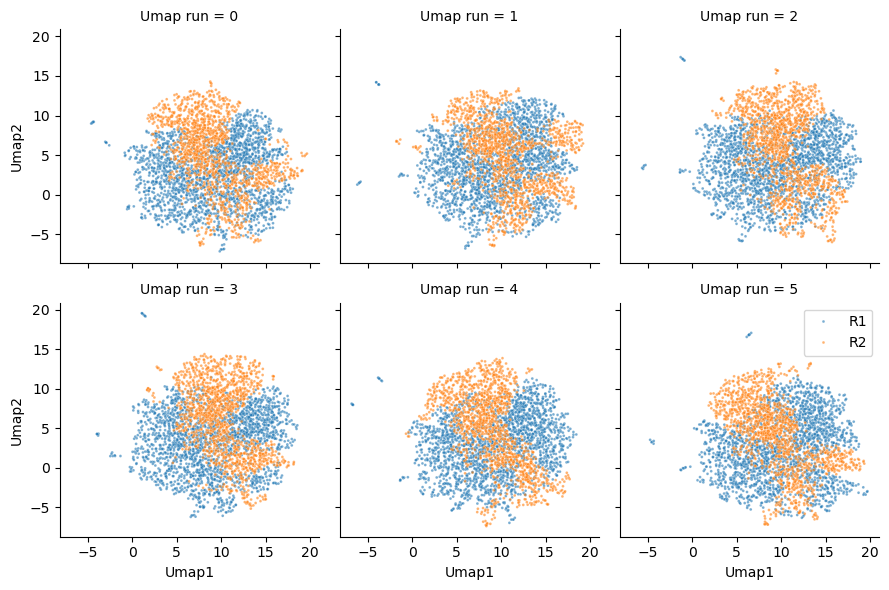

In [92]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2              # <---- set markersize here
g = sb.FacetGrid(data=mapped,col_wrap=3,col='Umap run')
g.map_dataframe(sb.scatterplot,data=mapped,x='Umap1',y='Umap2',
                hue='Region',alpha=0.6)
plt.legend()

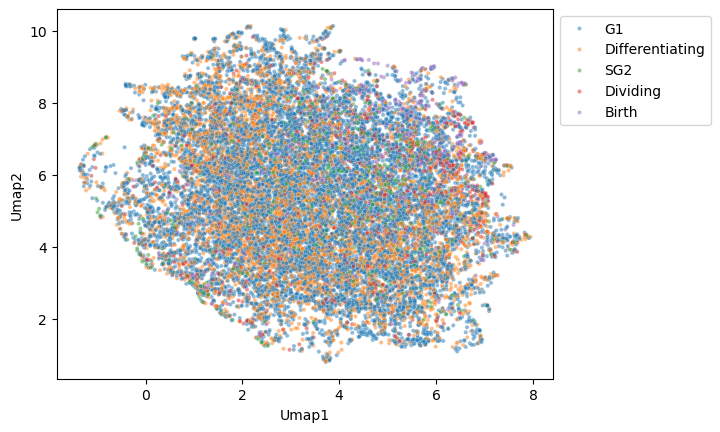

In [43]:
mpl.rcParams['lines.markersize'] = 3              # <---- set markersize here

sb.scatterplot(data=mapped[mapped['Cell state'] != 'NA'],x='Umap1',y='Umap2',
                hue='Cell state',alpha=0.5,)
               # size='Cell state',
               # size_order=['Birth','Dividing','Differentiating','SG2','G1'])
plt.legend(bbox_to_anchor=(1,1))


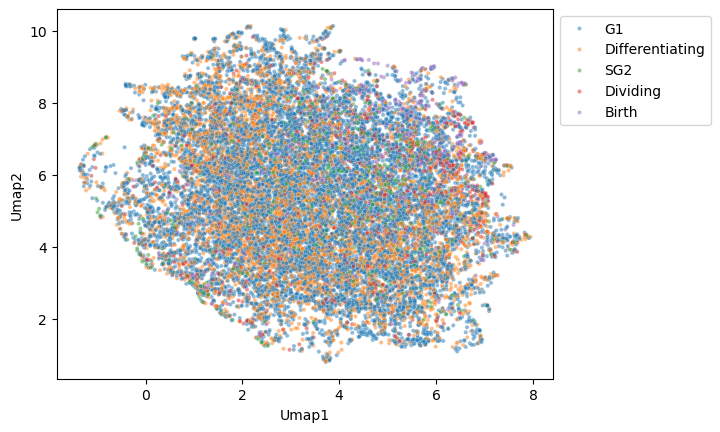

In [44]:
mpl.rcParams['lines.markersize'] = 3              # <---- set markersize here

sb.scatterplot(data=mapped[mapped['Cell state'] != 'NA'],x='Umap1',y='Umap2',
                hue='Cell state',alpha=0.5)
               # size='Cell state',
               # size_order=['Birth','Dividing','Differentiating','SG2','G1'])
plt.legend(bbox_to_anchor=(1,1))


Basicallly, all UMAP runs returns similar graphs

## Visualize UMAPs alongside cell state annotation

In [93]:
mpl.rcParams['lines.markersize'] = 5              # <---- set markersize here

reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_data)

basals['Umap1'] = embedding[:,0]
basals['Umap2'] = embedding[:,1]


ValueError: Length of values (3353) does not match length of index (8215)

In [ ]:
g = sb.FacetGrid(data= basals.droplevel(axis=1,level=1),col='Region')
g.map_dataframe(sb.scatterplot, data = basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Delaminate next frame',alpha=0.5,
              size='Delaminate next frame', size_order=[True,False])

In [ ]:

g = sb.FacetGrid(data= basals.droplevel(axis=1,level=1),col='Region')

g.map_dataframe(sb.scatterplot,data=basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Divide next frame',alpha=0.3,
              size='Divide next frame', size_order=[True,False])


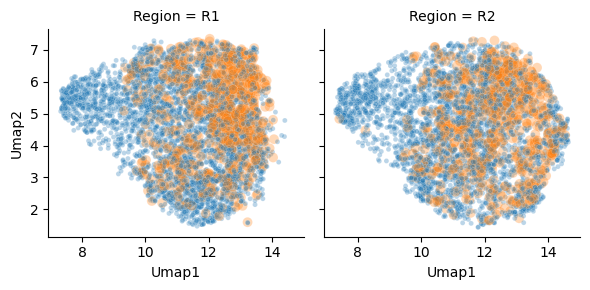

In [19]:

g = sb.FacetGrid(data= basals.droplevel(axis=1,level=1),col='Region')

g.map_dataframe(sb.scatterplot,data=basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',hue='Birth frame',alpha=0.3,
              size='Birth frame', size_order=[True,False])


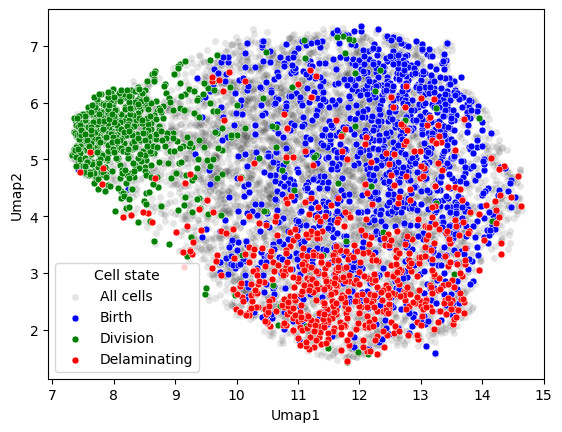

In [27]:
fig, ax = plt.subplots()

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',alpha=0.1, ax=ax, color='k')
sb.scatterplot(basals[basals['Birth frame','Meta']].droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='b',ax=ax)

sb.scatterplot(basals[basals['Divide next frame','Meta']].droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='g',ax=ax)

sb.scatterplot(basals[basals['Delaminate next frame','Meta']].droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='r',ax=ax)

plt.legend(title='Cell state',labels=['All cells','Birth','Division','Delaminating'])


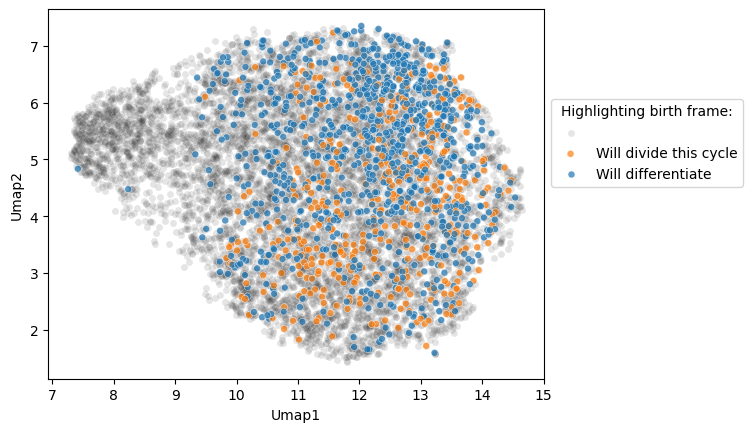

In [29]:
mpl.rcParams['lines.markersize'] = 5              # <---- set markersize here

fig, ax = plt.subplots()

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='k',alpha=0.1,ax=ax)
_df = basals[basals['Birth frame','Meta']]
sb.scatterplot(_df.droplevel(axis=1,level=1),
               x='Umap1',y='Umap2',alpha=0.7, ax=ax, hue='Will differentiate')

plt.legend(title='Highlighting birth frame:', loc='lower left',
           labels=['','Will divide this cycle', 'Will differentiate'],
          bbox_to_anchor=(1, 0.5))

<Axes: xlabel='Umap1', ylabel='Umap2'>

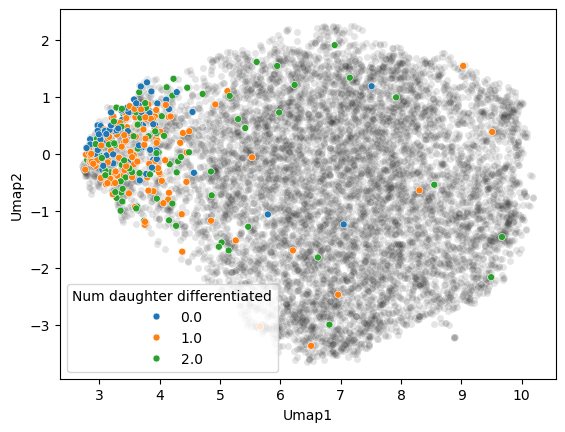

In [128]:
fig, ax = plt.subplots()

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='k',alpha=0.1,ax=ax)
_df = basals[basals['Divide next frame','Meta']]
sb.scatterplot(_df.droplevel(axis=1,level=1), palette='tab10',
               x='Umap1',y='Umap2',alpha=1, ax=ax, hue='Num daughter differentiated')

# plt.legend(title='Highlighting division frame:', loc='lower left',
#            labels=['','Two dividing daughters','Asymmetric daughters', 'Two differentiating'],
#           bbox_to_anchor=(0, 1))

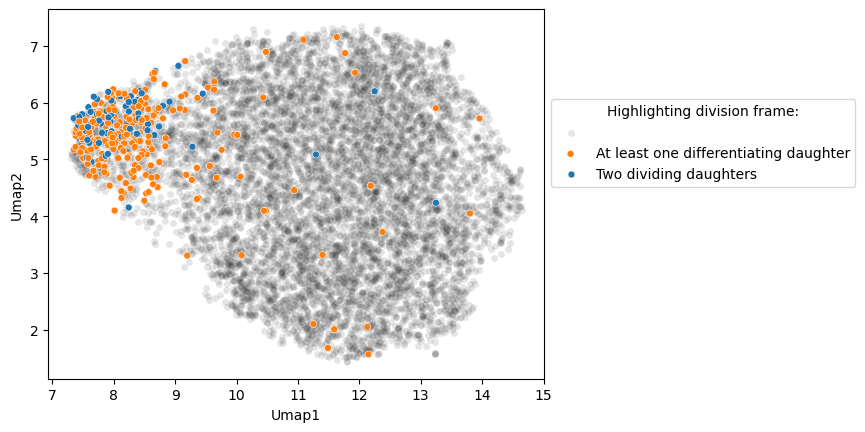

In [30]:
fig, ax = plt.subplots()

sb.scatterplot(basals.droplevel(axis=1,level=1),x='Umap1',y='Umap2',color='k',alpha=0.1,ax=ax)
_df = basals[basals['Divide next frame','Meta']]
sb.scatterplot(_df.droplevel(axis=1,level=1), palette='tab10',
               x='Umap1',y='Umap2',alpha=1, ax=ax, hue='At least one daughter differentiated',
              hue_order=[False,True])

plt.legend(title='Highlighting division frame:', loc='lower left',
           labels=['','At least one differentiating daughter','Two dividing daughters'],
          bbox_to_anchor=(1, 0.5))

## Isolated frames -> then UMAP

This seems unstable and probably highly dependent on hyperparameters.. did not explore yet

In [44]:
births = births[~births['Border','Meta'].astype(bool)]
divisions = divisions[~divisions['Border','Meta'].astype(bool)]

<Axes: xlabel='Umap1', ylabel='Umap2'>

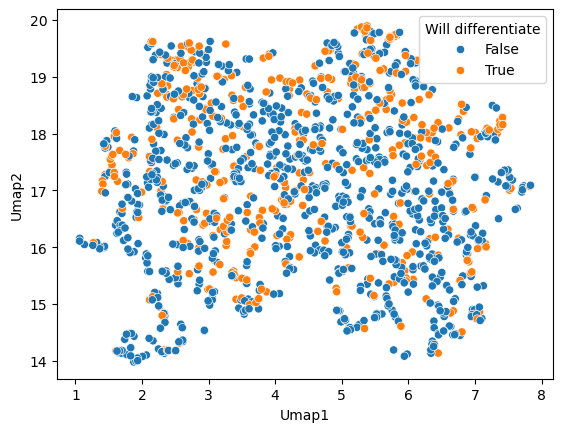

In [47]:
reducer = umap.UMAP()
all_meas = births.xs('Measurement',level=1,axis=1)
all_meas = all_meas.select_dtypes('number')
all_meas[np.isinf(all_meas)] = np.nan
all_meas = all_meas.dropna(axis=1)

scaled_df = preprocessing.StandardScaler().fit_transform(all_meas)
embedding = reducer.fit_transform(scaled_df)
embedding.shape
births['Umap1','Umap'] = embedding[:,0]
births['Umap2','Umap'] = embedding[:,1]

fig, ax = plt.subplots()

sb.scatterplot(births.droplevel(axis=1,level=1),
               x='Umap1',y='Umap2', ax=ax, hue='Will differentiate')


In [41]:
reducer = umap.UMAP()
all_meas = divisions.xs('Measurement',level=1,axis=1)
all_meas = all_meas.select_dtypes('number')
all_meas[np.isinf(all_meas)] = np.nan
all_meas = all_meas.dropna(axis=1)

scaled_df = preprocessing.StandardScaler().fit_transform(all_meas)
embedding = reducer.fit_transform(scaled_df)
embedding.shape
divisions['Umap1','Umap'] = embedding[:,0]
divisions['Umap2','Umap'] = embedding[:,1]
fig, ax = plt.subplots()

sb.scatterplot(divisions.droplevel(axis=1,level=1),
               x='Umap1',y='Umap2', ax=ax, hue='Num daughter differentiated')


<Axes: xlabel='Umap1', ylabel='Umap2'>

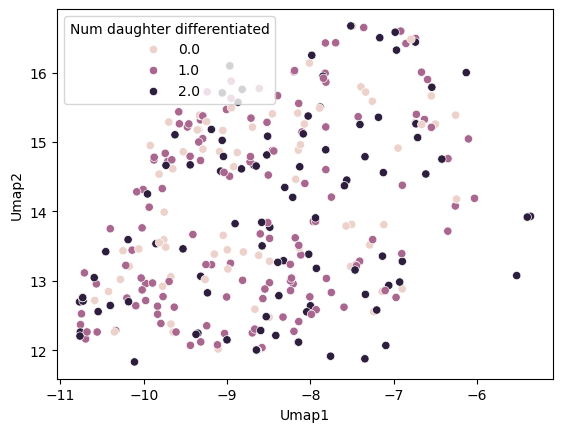